In [4]:
# Quickly reproduce the transcoder weight stuff

%load_ext autoreload
%autoreload 2

In [5]:
# SAE-SAE similiarities

import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sys
import os

sys.path.append("/home/phil/transcoders")  # Make unpickling work

# Loading and defining functions

In [6]:
# Load files
prefix = "../scripts/checkpoints/"

saes = {}

for layer in [0, 1]:
    saes[layer] = {}
    for seed in [42, 43]:
        saes[layer][seed] = {}
        for subdir in ["ln2_normalized", "mlp_out", "transcoder"]:
            path = f"{prefix}/32x_gelu_2l_{layer}/seed{seed}_{subdir}"
            # path = f"{prefix}/32x_gelu_1l/seed{seed}_{subdir}"
            # saes[subdir] = torch.load(f"{path}/final_sparse_autoencoder_gelu-2l_blocks.{layer}.ln2.hook_normalized_16384.pt")["state_dict"]

            # Load state dict
            for file in os.listdir(path):
                if file.endswith(".pt") and not file.endswith("sparsity.pt"):
                    saes[layer][seed][subdir] = torch.load(f"{path}/{file}")["state_dict"]
                    break

            # Add sparsity info
            for file in os.listdir(path):
                if file.endswith(".pt") and file.endswith("sparsity.pt"):
                    saes[layer][seed][subdir]["sparsity"] = torch.load(f"{path}/{file}")
                    break

In [7]:
saes[0][42]["ln2_normalized"].keys()

odict_keys(['W_enc', 'b_enc', 'W_dec', 'b_dec', 'sparsity'])

In [20]:
saes[0][42]["transcoder"].keys()

odict_keys(['W_enc', 'b_enc', 'W_dec', 'b_dec', 'b_dec_out', 'sparsity'])

In [17]:
@torch.no_grad
def get_top_cossims(mat1, mat2, auto_transpose=True, auto_direction=True, return_all=False, max_dim=0):
    """Get top cosine similarities between two matrices."""
    # Manage device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    mat1 = mat1.to(device)
    mat2 = mat2.to(device)

    # Transpose to get the right shape
    d1, d2 = mat1.shape
    d3, d4 = mat2.shape

    # Optionally transpose matrix 2
    if auto_transpose and d2 != d4 and d2 == d3:
        mat2 = mat2.T

    # Make sure shape[0] > shape[1]
    if auto_direction and d1 < d2:
        mat1 = mat1.T
        mat2 = mat2.T

    # Normalize matrices
    mat1 /= torch.norm(mat1, dim=1, keepdim=True)
    mat2 /= torch.norm(mat2, dim=1, keepdim=True)

    # Get cossims as dot-products of normalized matrices
    cossims = mat1 @ mat2.T
    print("Cosine sims shape:", cossims.shape)

    # Return all cosine sims or max per row
    if return_all:
        return cossims
    elif mat1 is mat2:
        return (cossims - torch.eye(cossims.shape[0]).to(device)).max(dim=max_dim).values
    else:
        return cossims.max(dim=1).values


# Example
get_top_cossims(saes[0][42]["ln2_normalized"]["W_enc"], saes[0][43]["ln2_normalized"]["W_enc"]).shape

Cosine sims shape: torch.Size([16384, 16384])


torch.Size([16384])

In [10]:
def torch_histogram(vals, ax):
    """Get a histogram of a tensor and plot on axes. Torch version is a lot faster"""
    mn, mx = vals.min().item(), vals.max().item()
    hist_vals = torch.histc(vals, bins=100, min=vals.min(), max=vals.max())
    ax.plot(np.linspace(mn, mx, 100), hist_vals.cpu().numpy())

# Cosine sims

Cosine sims shape: torch.Size([16384, 16384])
Cosine sims shape: torch.Size([16361, 16384])
Cosine sims shape: torch.Size([16361, 16384])
Cosine sims shape: torch.Size([16374, 16384])
Cosine sims shape: torch.Size([16374, 16384])
Cosine sims shape: torch.Size([16374, 16361])
Cosine sims shape: torch.Size([15671, 16384])
Cosine sims shape: torch.Size([15671, 16384])
Cosine sims shape: torch.Size([15671, 16361])
Cosine sims shape: torch.Size([15671, 16374])
Cosine sims shape: torch.Size([16153, 16384])
Cosine sims shape: torch.Size([16153, 16384])
Cosine sims shape: torch.Size([16153, 16361])
Cosine sims shape: torch.Size([16153, 16374])
Cosine sims shape: torch.Size([16153, 15671])


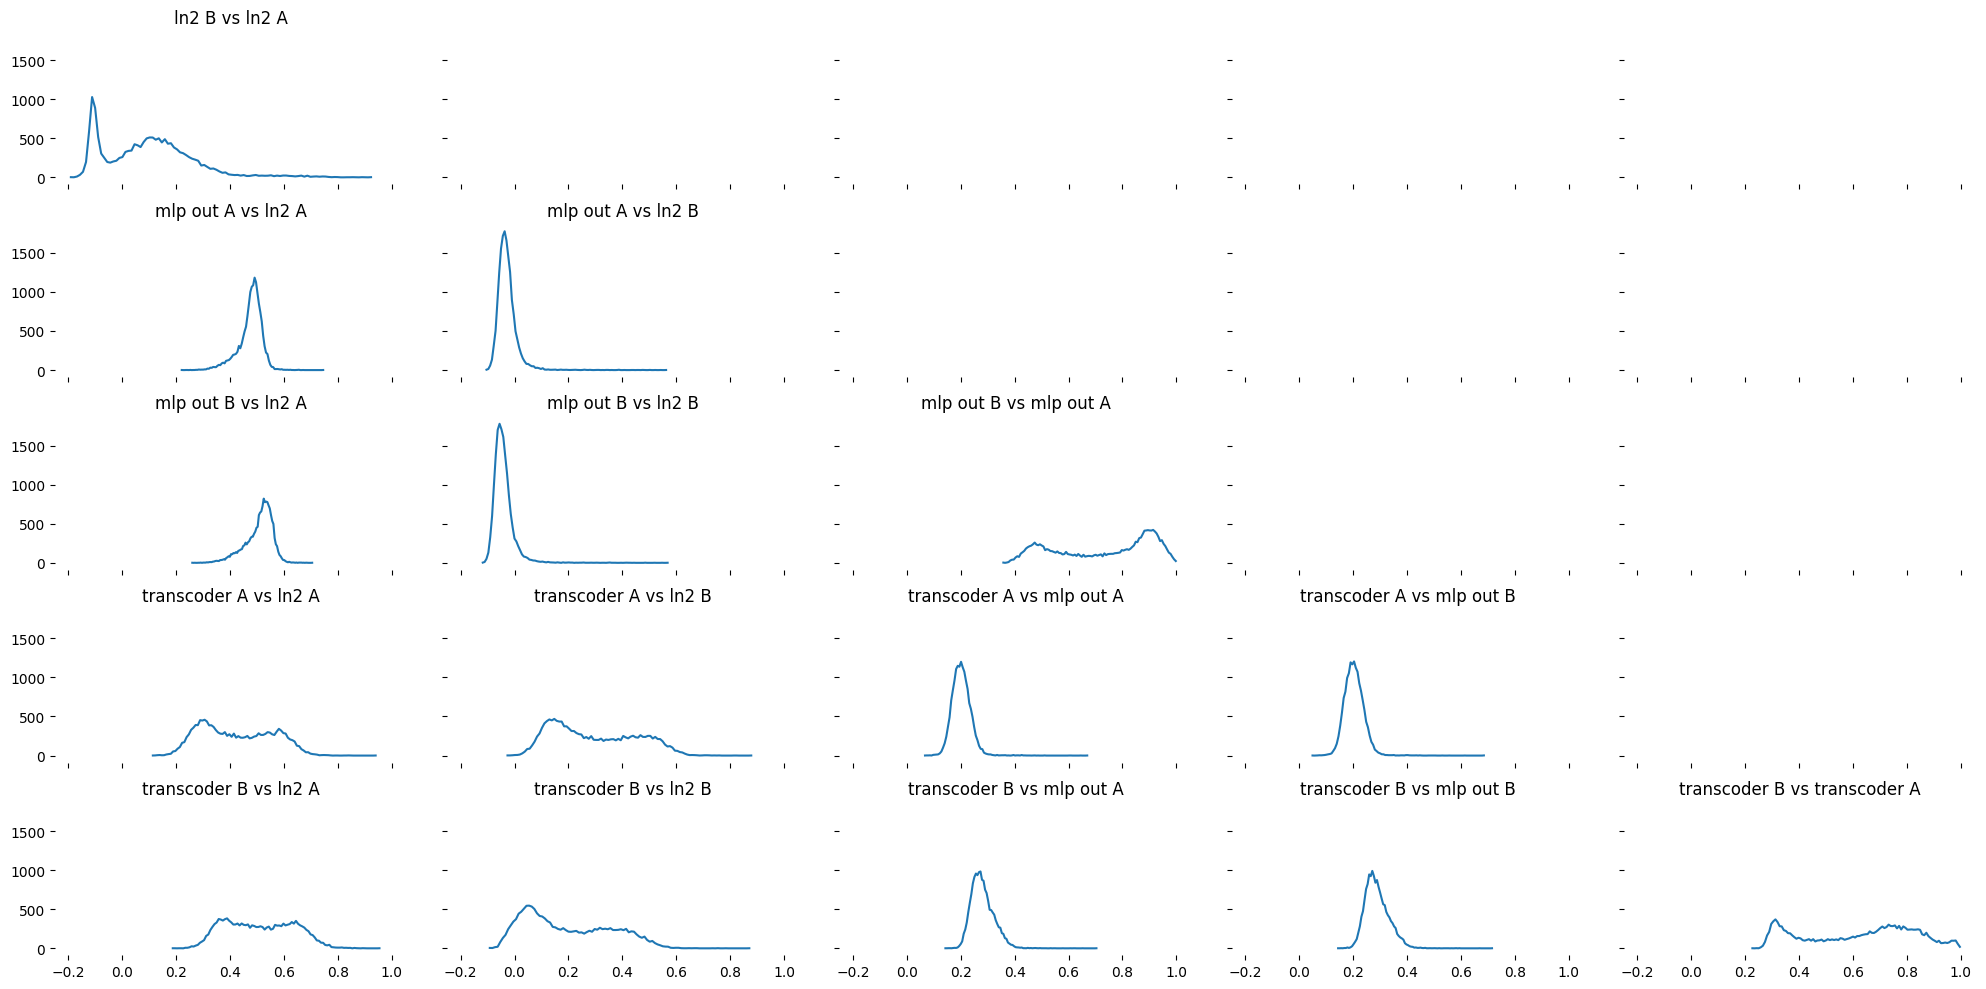

In [11]:
# Plot histogram of all cosine sims

s_a = saes[0][42]
s_b = saes[0][43]

all_saes = [
    s_a["ln2_normalized"],
    s_b["ln2_normalized"],
    s_a["mlp_out"],
    s_b["mlp_out"],
    s_a["transcoder"],
    s_b["transcoder"],
]
all_saes_names = ["ln2 A", "ln2 B", "mlp out A", "mlp out B", "transcoder A", "transcoder B"]

fig, axs = plt.subplots(len(all_saes) - 1, len(all_saes) - 1, figsize=(20, 10), sharex=True, sharey=True)

# Plot lower triangle of histograms
for i, sae1 in enumerate(all_saes):
    for j, sae2 in enumerate(all_saes):
        if i <= j:
            continue
        # Use (i-1, j) to index into the lower triangle

        # Filter by sparsity
        m1 = sae1["W_enc"][:, sae1["sparsity"] > -5]
        m2 = sae2["W_enc"][:, sae2["sparsity"] > -5]

        # Get and plot cosine sims
        cossims = get_top_cossims(m1, m2)
        torch_histogram(cossims, axs[i - 1, j])
        axs[i - 1, j].set_title(f"{all_saes_names[i]} vs {all_saes_names[j]}")

# Clean up axes
# Remove box around plots
for ax in axs.flatten():
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.show()

Cosine sims shape: torch.Size([16384, 16384])
Cosine sims shape: torch.Size([16361, 16384])
Cosine sims shape: torch.Size([16361, 16384])
Cosine sims shape: torch.Size([16374, 16384])
Cosine sims shape: torch.Size([16374, 16384])
Cosine sims shape: torch.Size([16374, 16361])
Cosine sims shape: torch.Size([15671, 16384])
Cosine sims shape: torch.Size([15671, 16384])
Cosine sims shape: torch.Size([15671, 16361])
Cosine sims shape: torch.Size([15671, 16374])
Cosine sims shape: torch.Size([16153, 16384])
Cosine sims shape: torch.Size([16153, 16384])
Cosine sims shape: torch.Size([16153, 16361])
Cosine sims shape: torch.Size([16153, 16374])
Cosine sims shape: torch.Size([16153, 15671])


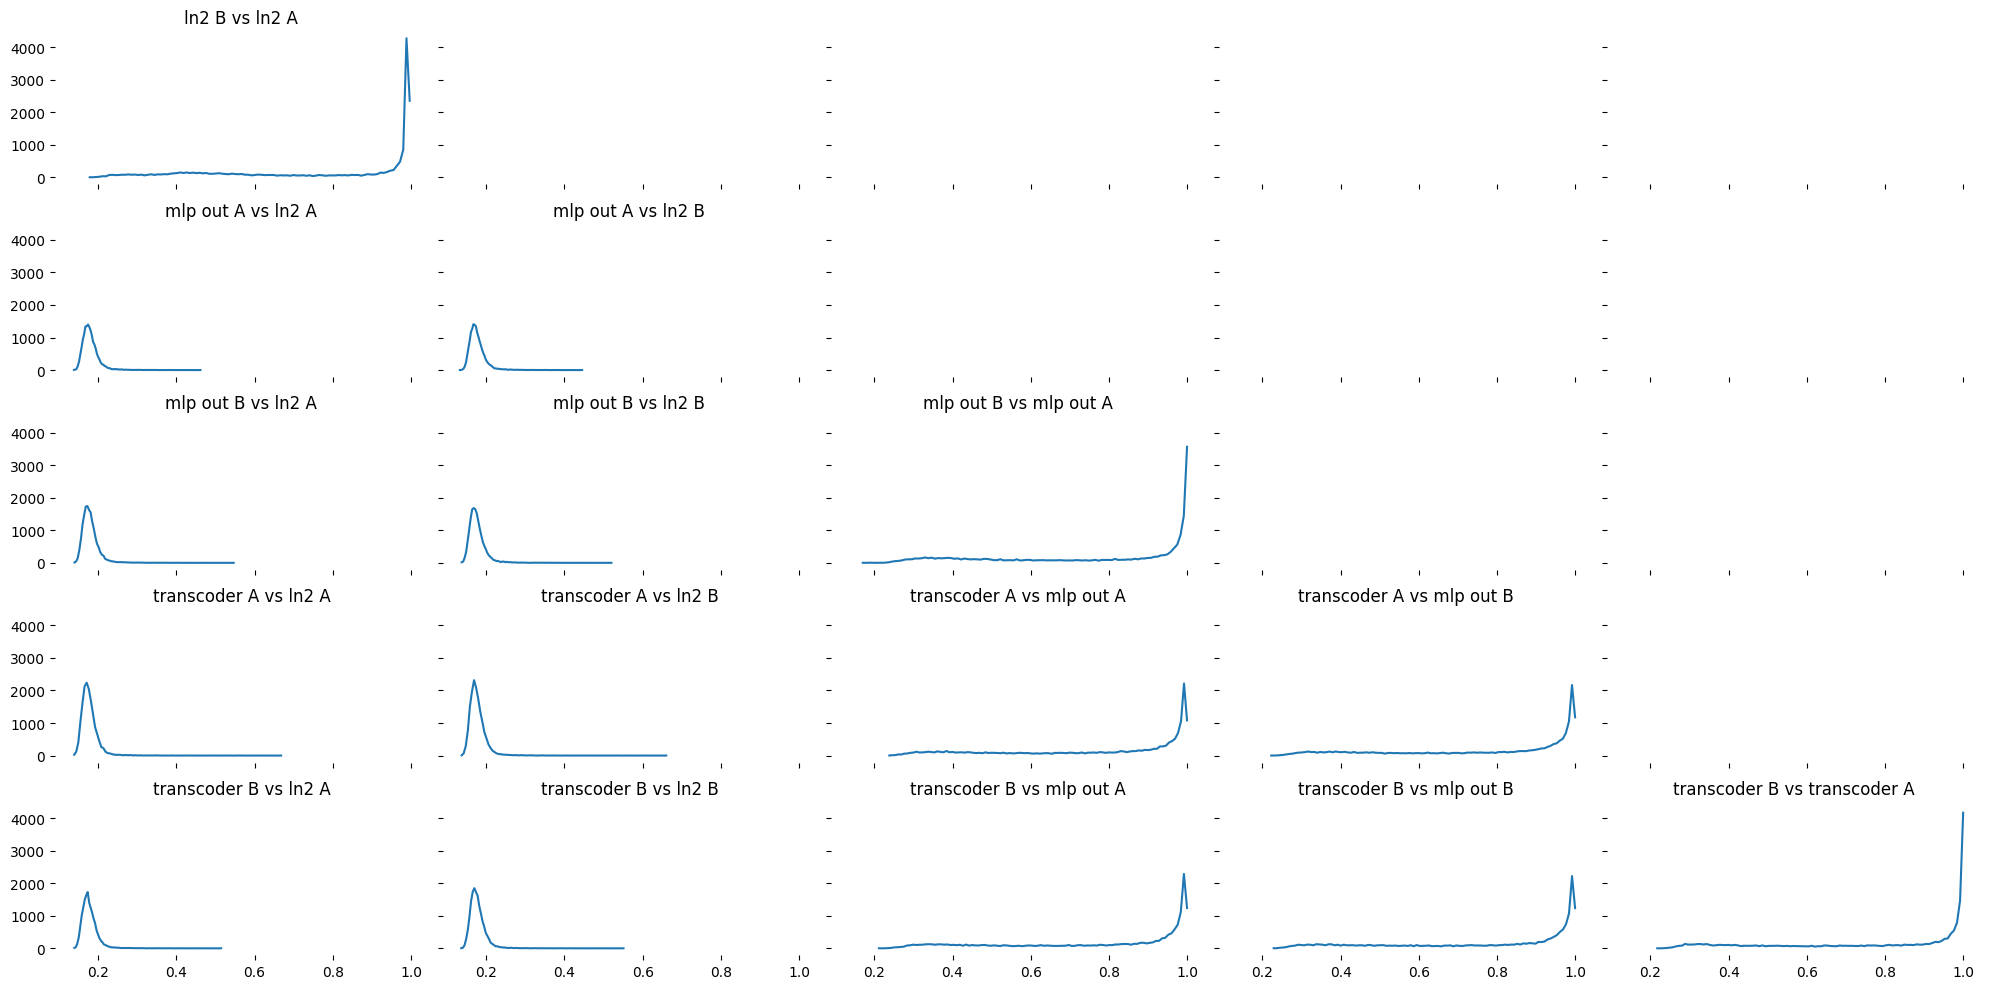

In [12]:
# Same for decoder vectors

fig, axs = plt.subplots(len(all_saes) - 1, len(all_saes) - 1, figsize=(20, 10), sharex=True, sharey=True)

# Plot lower triangle of histograms
for i, sae1 in enumerate(all_saes):
    for j, sae2 in enumerate(all_saes):
        if i <= j:
            continue

        # Filter by sparsity
        m1 = sae1["W_dec"][sae1["sparsity"] > -5]
        m2 = sae2["W_dec"][sae2["sparsity"] > -5]

        # Get and plot cosine sims
        cossims = get_top_cossims(m1, m2)
        torch_histogram(cossims, axs[i - 1, j])
        axs[i - 1, j].set_title(f"{all_saes_names[i]} vs {all_saes_names[j]}")

# Clean up axes
# Remove box around plots
for ax in axs.flatten():
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.show()

# Cossim scatter plots

Cosine sims shape: torch.Size([16384, 16384])
Cosine sims shape: torch.Size([16384, 16384])


Text(0.5, 1.0, 'Max cossims, transcoder W_dec vs. mlp_out W_dec')

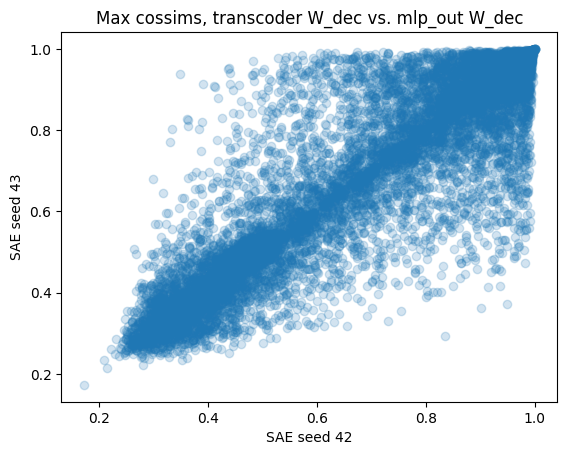

In [13]:
# Max cosine sim with two different SAEs:

cs1 = get_top_cossims(s_a["transcoder"]["W_dec"], s_a["mlp_out"]["W_dec"])
cs2 = get_top_cossims(s_a["transcoder"]["W_dec"], s_b["mlp_out"]["W_dec"])

plt.scatter(cs1.cpu().numpy(), cs2.cpu().numpy(), alpha=0.2)
plt.xlabel("SAE seed 42")
plt.ylabel("SAE seed 43")
plt.title("Max cossims, transcoder W_dec vs. mlp_out W_dec")

Cosine sims shape: torch.Size([16384, 16384])
Cosine sims shape: torch.Size([16384, 16384])


Text(0.5, 1.0, 'Max cossims, transcoder W_enc vs. mlp_out W_enc')

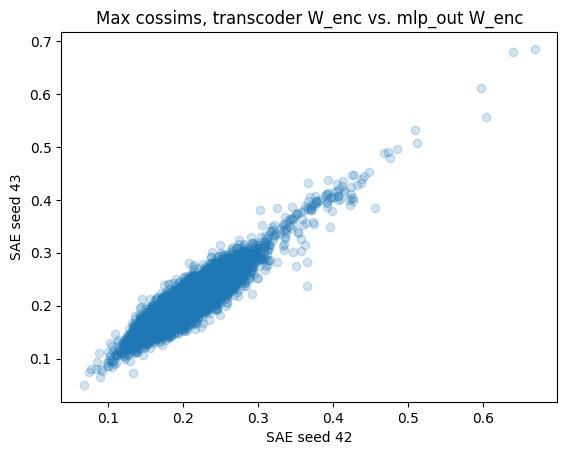

In [14]:
# Max cosine sim with two different SAEs:

cs1 = get_top_cossims(s_a["transcoder"]["W_enc"], s_a["mlp_out"]["W_enc"])
cs2 = get_top_cossims(s_a["transcoder"]["W_enc"], s_b["mlp_out"]["W_enc"])

plt.scatter(cs1.cpu().numpy(), cs2.cpu().numpy(), alpha=0.2)
plt.xlabel("SAE seed 42")
plt.ylabel("SAE seed 43")
plt.title("Max cossims, transcoder W_enc vs. mlp_out W_enc")

Cosine sims shape: torch.Size([16384, 16384])
Cosine sims shape: torch.Size([16384, 16384])


Text(0.5, 1.0, 'Max cossims, SAE W_dec vs. mlp_out W_dec')

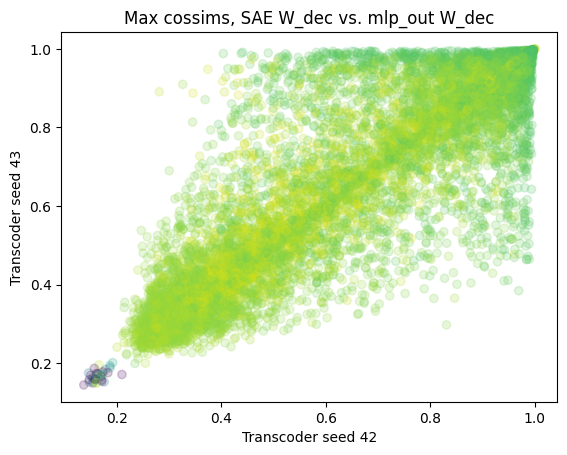

In [15]:
# Max cosine sim with two different SAEs:

mtx_name = "W_dec"

cs1 = get_top_cossims(s_a["mlp_out"][mtx_name], s_a["transcoder"][mtx_name])
cs2 = get_top_cossims(s_a["mlp_out"][mtx_name], s_b["transcoder"][mtx_name])

plt.scatter(cs1.cpu().numpy(), cs2.cpu().numpy(), alpha=0.2, c=s_a["mlp_out"]["sparsity"])
plt.xlabel("Transcoder seed 42")
plt.ylabel("Transcoder seed 43")
plt.title(f"Max cossims, SAE {mtx_name} vs. mlp_out {mtx_name}")

Cosine sims shape: torch.Size([16384, 16384])
Cosine sims shape: torch.Size([16384, 16384])


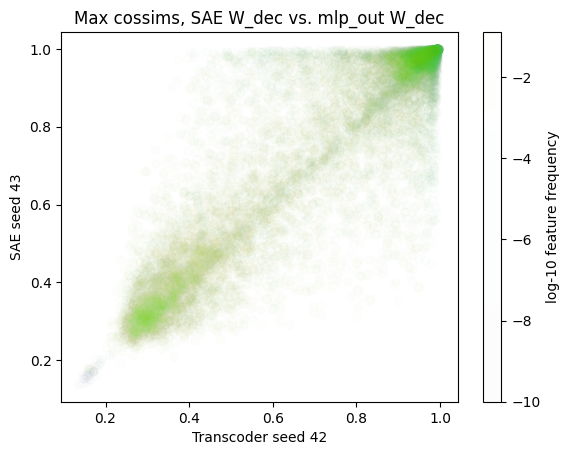

In [19]:
# Max cosine sim with two different SAEs:

mtx_name = "W_dec"

cs1 = get_top_cossims(s_a["mlp_out"][mtx_name], s_a["transcoder"][mtx_name], max_dim=0)
cs2 = get_top_cossims(s_a["mlp_out"][mtx_name], s_b["mlp_out"][mtx_name], max_dim=0)

plt.scatter(cs1.cpu().numpy(), cs2.cpu().numpy(), alpha=0.01, c=s_a["mlp_out"]["sparsity"])
plt.xlabel("Transcoder seed 42")
plt.ylabel("SAE seed 43")
plt.title(f"Max cossims, SAE {mtx_name} vs. mlp_out {mtx_name}")
plt.colorbar(label="log-10 feature frequency")